In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn

from itertools import islice, count
%matplotlib inline

In [2]:
import pycosmicstar.lcdmcosmology as lcdmcos

lcdmlib not imported, using pure python version of sigma


In [3]:
# import objetive function
import objectivefunction as of

# import regularization module
os.chdir("./optimization-regularization/regularization/")
import regularization as reg

In [4]:
# load lcdm model
lcdmUniverser = lcdmcos.Lcdmcosmology(omegam=0.24,
                              omegab=0.04, 
                              omegal=0.73,
                               h=0.7)

In [5]:
delta_mbh = 0.1 # pass in m_bh
delta_z = 0.1 # pass in z
dz = -delta_z
dm = delta_mbh
D = dz/dm 
m0 = 7.7 # inicial mass
mf = 9.6 # final mass
z0 = 20.0 # inicial redshift
zf = 0.3 # final redshift

In [6]:
# load csv with experimental data
os.chdir("/home/peregrinus/Arquivos/cap/problemas-inversos/projeto")
df = pd.read_csv('mean_LBH.csv')

In [7]:
# find the number of points to z and m_bh to build the matrix of
# mass distribution
num_pontos_z = len(df.z.unique())
num_pontos_m = len(df.massBH.unique())

In [8]:
# preparer matrix nbh_obs
nbh_obs = np.empty((num_pontos_m, num_pontos_z))
nbh_obs.fill(np.nan)

In [9]:
# load data from csv to matrix
for l in range(0, df.shape[0]):
    i = int(np.around(df.z[l]*10.0, decimals=1) - 3.0)
    j = int(np.around(df.massBH[l]*10.0, decimals=1) - 77.0)
    nbh_obs[j][i] = df.nObjects[l]

In [10]:
class mbh_mean_dt(object):
    """
    This class implement the average of the varitation of m_bh in relation to time
    """
    def __init__(self, lb_mean_par, mbh_par, alpha_par, tau_par, eta, c = 3e8):
        self.__const1 = (1/c**2.0)*((1-eta)/eta)
        self.__lb_mean_par = lb_mean_par 
        self.__mbh_par = mbh_par 
        self.__alpha_par = alpha_par  
        self.__tau_par = tau_par
        
    def __call__(self, mbh, tz):
        return self.__const1 * self.__lb_mean_par * (mbh/self.__mbh_par)**self.__alpha_par * (self.__tau_par/tz) * np.exp(-tz/self.__tau_par)
    
    @property
    def alpha_par(self):
        return self.__alpha_par

In [11]:
class mbh_mean_dt_dm(object):
    """
    This class implement the derivative in relation to m_bh for the class mbh_mean_dt
    """
    def __init__(self, mbh_mean_dt):
        self.__alpha_par = mbh_mean_dt.alpha_par
        self.__mbh_mean_dt = mbh_mean_dt
    
    def __call__(self, mbh, tz):
        return (self.__alpha_par/mbh) * self.__mbh_mean_dt(mbh, tz)

In [12]:
class V(object):
    """
    """
    def __init__(self, mmt, mmtm):
        self.__mmt = mmt
        self.__mmtm = mmtm

    def __call__(self, mbh, tz, dm):
        return self.__mmtm(mbh, tz) + self.__mmt(mbh, tz)/dm

In [13]:
#        best fit         bias      error 
# lb_mean_par : 3.05e47 : 6.65e45  : 3.14e46
# mbh_par     : 2.19e11 : 1.88e10  : 4.88e10
# alpha_par   : 2.71e-1 : -1.29e-4 : 1.18e-2
# tau_par     : 4.81e9  : 1.05e7   : 1.69e8

# load the class defined above with values find by bootstrap regresssion from experimental
# data

mmt = mbh_mean_dt(3.05e7, 2.19e11, 2.71e-1, 4.81e9, 0.1)
mmtm = mbh_mean_dt_dm(mmt)
auxiliarV = V(mmt, mmtm)

In [14]:
# L is a representative function to dt/dz in z = zj
L = lambda z: lcdmUniverser.dt_dz(z)

In [15]:
# A the operator of time evolution
A = np.identity(num_pontos_m)

# the matriz At for time evolution has dependencie in time, 
# so need to be remake for each time

j = 0 # the index j represent time(redshift)
zj = dz*j + z0 # the value of the redshift in pass j

# the value of time to zj, consider the cosmologic model
tzj = lcdmUniverser.dt_dz(zj)*delta_z 

while zj > 0.2:
    At = np.zeros((num_pontos_m, num_pontos_m))
    
    lzj = L(zj)
    for i in islice(count(), 1, num_pontos_m-1):
        mi = dm*i + m0    
        if i-1 >= 0:
            At[i][i-1] = lzj*D*mmt(mi, tzj)
        At[i][i] = 1 - dz*auxiliarV(mi, tzj, dm)*lzj

    mi = dm*0 + m0
    At[0][0] = 1 - dz*L(zj)*auxiliarV(mi, tzj, dm) + lzj*D*mmtm(mi, tzj)
    mi = dm*(num_pontos_m-1) + m0
    At[num_pontos_m-1][num_pontos_m-1] = 1 - dz*L(zj)*auxiliarV(mi, tzj, dm) + lzj*D*mmtm(mi, tzj)
    
    A = np.dot(A, At)
    zj += dz
    tzj += lcdmUniverser.dt_dz(zj)*delta_z

In [16]:
# define gaussian function as initial condition,
# to avaliate the direct model
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [17]:
m = np.linspace(m0, mf, num_pontos_m)

In [18]:
# generate initial test condition to evolve in time
test_initial_condition = gaussian(m, (m0+mf)/2., 1.)

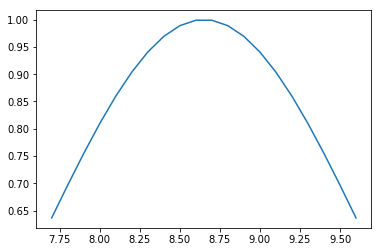

In [19]:
from matplotlib import pyplot as mp
mp.plot(m, test_initial_condition)
mp.show()

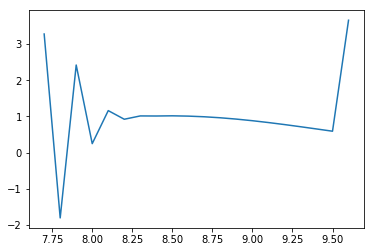

In [20]:
# evolve the initial condition using the operator A,
# for time evolution, and plot the same
test_initial_condition_evolve = A.dot(test_initial_condition)
mp.plot(m, test_initial_condition_evolve)
mp.show()

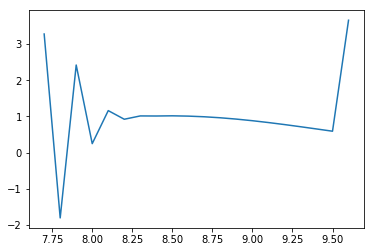

In [21]:
# add noise to the evolve configuration
sigma = 0.0
np.random.seed(seed=1234)
test_initial_condition_evolve += sigma*np.random.uniform(low=0.0, high=1.0, size=num_pontos_m)
mp.plot(m, test_initial_condition_evolve)
mp.show()

In [22]:
# load regularization, Tiknov order 0

alpha = 0
tik0 = reg.TikhonovOrder0(num_pontos_m)

J = of.FuncJ(alpha, A.dot, tik0)
Jmeasure = lambda f: J(f, test_initial_condition_evolve)

def evaluate(individual):
    return (Jmeasure(individual),)

In [23]:
from deap import algorithms
from deap import base
from deap import creator
from deap import tools

In [24]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

In [25]:
toolbox = base.Toolbox()

In [26]:
np.random.seed(1234)
toolbox.register("attr_float", np.random.uniform, 0., 1.)
toolbox.register("individual", 
                 tools.initRepeat,
                 creator.Individual,
                 toolbox.attr_float,
                 n=num_pontos_m)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [27]:
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=6)

In [28]:
pop = toolbox.population(n=500)

In [29]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

#logbook = tools.Logbook()
#logbook.record(gen=0, evals=30, **record)

In [30]:
result, logbook = algorithms.eaSimple(pop, 
                             toolbox, 
                             cxpb=0.5, 
                             mutpb=0.5, 
                             ngen=200, 
                             stats=stats, verbose=True)

gen	nevals	avg    	std    	min    	max    
0  	500   	320.722	166.366	63.3115	971.109
1  	392   	596.229	682.198	55.9777	4716.7 
2  	374   	579.615	696.005	58.2574	4997.49
3  	384   	573.074	678.647	39.8037	4678.8 
4  	374   	520.219	646.394	39.8037	5372.53
5  	359   	532.862	645.275	33.7652	4721.17
6  	371   	462.212	604.022	33.7652	4299.63
7  	375   	509.593	664.931	33.7652	5137.73
8  	386   	472.097	643.792	29.926 	4320.85
9  	355   	477.215	687.214	22.776 	4678.17
10 	378   	497.45 	715.942	21.7241	5621.01
11 	371   	438.18 	588.454	21.7241	3740.49
12 	362   	503.612	745.652	21.7241	4788.77
13 	391   	453.491	657.253	18.2732	4470.11
14 	371   	477.779	746.135	17.4022	4583.37
15 	371   	462.899	644.462	17.4022	4862.77
16 	372   	480.25 	702.382	13.4097	4403.49
17 	389   	525.426	816.78 	13.4097	6313.47
18 	362   	395.523	669.487	12.8409	6778.99
19 	378   	395.691	677.981	12.8409	4652.19
20 	394   	426.013	591.965	12.8409	3814.59
21 	370   	419.355	627.399	11.9332	4454.5 
22 	364   	

193	379   	430.088	708.747	2.77109	6314.26
194	384   	448.651	683.825	2.77109	5526.33
195	383   	348.322	599.875	2.76685	3960.07
196	378   	416.825	608.479	2.75903	3440.32
197	374   	365.9  	594.848	2.75477	3278.2 
198	368   	402.359	689.803	2.74683	7157.4 
199	377   	372.896	658.353	2.75064	4488.46
200	359   	347.815	584.757	2.74918	3767.24


In [31]:
best = tools.selBest(pop, k=1)[0]
print('Current best fitness:', evaluate(best))

('Current best fitness:', (2.7491828425824654,))


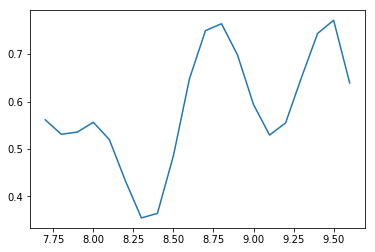

In [32]:
mp.plot(m, best)
mp.show()

# Make a new avaliation of the direct method, using the evolve operator in the experimental data

In [33]:
num_pontos_m = 11
A = np.identity(num_pontos_m)

# the matriz At for time evolution has dependencie in time, so need to be remake for each time
j = 0
zj = dz*j + z0
tzj = lcdmUniverser.dt_dz(zj)*delta_z
m0 = 8.3


while zj > 1.5:
    At = np.zeros((num_pontos_m, num_pontos_m))
    
    lzj = L(zj)
    for i in islice(count(), 1, num_pontos_m-1):
        mi = dm*i + m0    
        if i-1 >= 0:
            At[i][i-1] = lzj*D*mmt(mi, tzj)
        At[i][i] = 1 - dz*auxiliarV(mi, tzj, dm)*lzj

    mi = dm*0 + m0
    At[0][0] = 1 - dz*L(zj)*auxiliarV(mi, tzj, dm) + lzj*D*mmtm(mi, tzj)
    mi = dm*(num_pontos_m-1) + m0
    At[num_pontos_m-1][num_pontos_m-1] = 1 - dz*L(zj)*auxiliarV(mi, tzj, dm) + lzj*D*mmtm(mi, tzj)
    
    A = np.dot(A, At)
    zj += dz
    tzj += lcdmUniverser.dt_dz(zj)*delta_z

In [34]:
mbh_83_94_t12 = nbh_obs[12][6:17]
mbh_83_94_t13 = (nbh_obs[13][6:17])

In [35]:
A.dot(mbh_83_94_t13)

array([ 1230.76909852,  -418.22761216,  1029.81271423,    36.06586584,
         433.02775572,   571.09704014,   312.04771434,   138.65358202,
         432.45023275,    20.55861962,  1144.28206162])

In [36]:
print(np.abs(mbh_83_94_t12-A.dot(mbh_83_94_t13))/mbh_83_94_t12)

[ 4.04413565  2.27508418  2.09253067  0.90508983  0.27736801  0.7253687
  0.14036442  0.44091298  0.68925872  0.89292386  6.02013535]


In [37]:
# error 
print(np.abs(mbh_83_94_t12-A.dot(mbh_83_94_t13)))

[ 986.76909852  746.22761216  696.81271423  343.93413416   94.02775572
  240.09704014   50.95228566  109.34641798  176.45023275  171.44138038
  981.28206162]
